# Paddy disease classification
Kaggle competition
https://www.kaggle.com/competitions/paddy-disease-classification

### Setting up env and downloading data from kaggle

In [1]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
  colab_flag = True
else:
  colab_flag = False

if colab_flag == True:
   print("Running in Colab...")
   #Install Kaggle API
   ! pip install -q kaggle
   #Install Huggingface Datasets lib
   ! pip install -q datasets
   #Install Huggingface transformers & the sentencepiece
   ! pip install -q transformers[sentencepiece,torch]
   #Intall Timm for Pytorch Image Models
   ! pip install -q timm
   print("...Installed required dependencies")
else:
   print("Assuming running in local environment...")

Running in Colab...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.3 MB/s eta 0:00:00
...Installed required dependencies


In [2]:
if colab_flag == True:
  import json
  from google.colab import drive
  drive.mount('/content/drive/')

  # Set the file path
  file_path = '/content/drive/MyDrive/dtu/fastAI/04_NLP/kaggle_api.json'

  # Check if the file exists
  if os.path.exists(file_path):
      # Load the JSON file
      with open(file_path) as f:
          creds = json.load(f)
      print('Sucesfully set kaggle credentials')
  else:
      # Handle the case when the file does not exist
      creds = None  # or any other appropriate action you want to take
      print('Error: File not found, Credentials NOT set')
else:
    import json
    file_path = "../secrets/kaggle_api.json"
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the JSON file
        with open(file_path) as f:
            creds = json.load(f)
        print('Sucesfully set kaggle credentials')
    else:
        # Handle the case when the file does not exist
        creds = None  # or any other appropriate action you want to take
        print('Error: File not found, Credentials NOT set')

Mounted at /content/drive/
Sucesfully set kaggle credentials


In [3]:
#using `pathlib.Path to work with paths in Python`
from pathlib import Path
#Set path for the titanic dataset
path = Path('paddy-disease-classification')

if path.exists():
  print('Data folder exists')
else:
  print('Data not detected, starting download')
  #Setup of kaggle credentials to use the API for downloading dataset
  cred_path = Path('~/.kaggle/kaggle.json').expanduser()
  if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(json.dumps(creds))
    #If not Json
    #cred_path.write_text(creds)
    cred_path.chmod(0o600)
  import zipfile,kaggle
  #Download data
  kaggle.api.competition_download_cli(str(path))
  #Unzip at path
  zipfile.ZipFile(f'{path}.zip').extractall(path)

#Verifying the the local content
!ls {path}

Data not detected, starting download


100%|██████████| 1.02G/1.02G [00:34<00:00, 32.0MB/s]



sample_submission.csv  test_images  train.csv  train_images


# Testing GPU limitation
It's really helpful to be able to quickly try a few models and image sizes and find out what will run successfully. To make this quick, we can just grab a small subset of the data for running short epochs -- the memory use will still be the same, but it'll be much faster.

One easy way to do this is to simply pick a category with few files in it. Here's our options:


In [19]:
from fastai.vision.all import *
set_seed(42)

train_path = path/'train_images'
train_files = get_image_files(train_path)

test_path = path/'test_images'
test_files = get_image_files(train_path)

In [20]:
#Simply contains the filename of all the images in the given folder
test_files[0:3]

(#3) [Path('paddy-disease-classification/train_images/brown_spot/107972.jpg'),Path('paddy-disease-classification/train_images/brown_spot/100275.jpg'),Path('paddy-disease-classification/train_images/brown_spot/101929.jpg')]

In [21]:
df_test = pd.read_csv(path/'train.csv')
df_test.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [22]:
df_test.label.value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

In [23]:
train_path_subset = path/'train_subset'/'bacterial_panicle_blight'

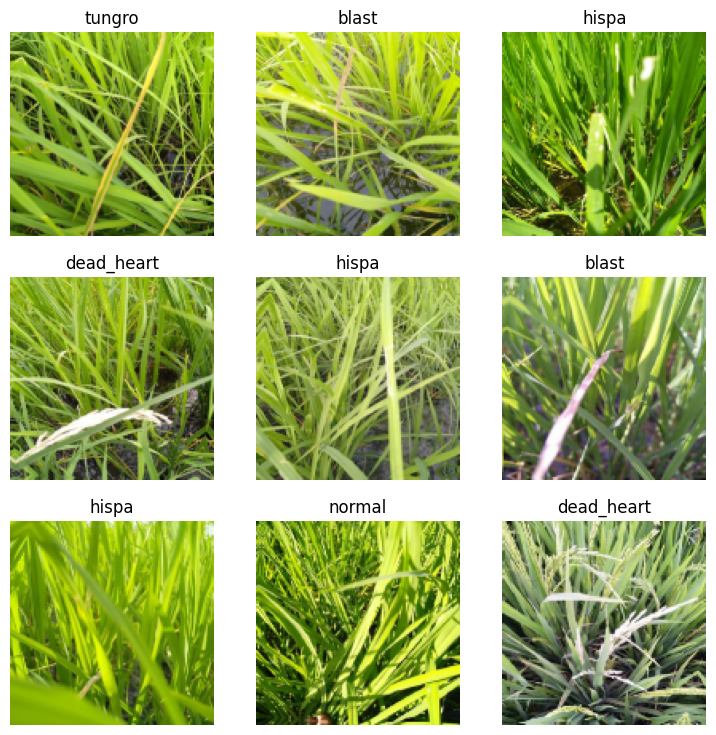

In [6]:
dls = ImageDataLoaders.from_folder(train_path,
                                        valid_pct=0.2,
                                        seed=42,
                                        item_tfms=Resize(480, method='squish'),
                                        #Data augmentation done on GPU, transformations of the data taking
                                        #a subset of the image (128) and applying random transformations
                                        batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch()

### The first model
Best models for finetuning, 100 different models, evaluated on the Pets dataset and a sattelite imagedataset (Planet): https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning . **One year old**

To begin with, choose decent accuracy but FAST model = Resnet26d


In [ ]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

Find LR timing:
- Colab: 1 min
- Local CPU: 3 min 46 sec

SuggestedLRs(valley=0.0012022644514217973, slide=0.00363078061491251)

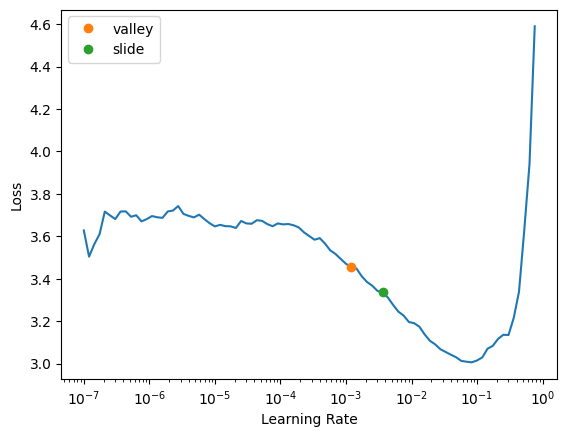

In [ ]:
learn.lr_find(suggest_funcs=(valley, slide))

Generally speaking the reccomendations from fastAI is conservative to be on the safe side, so typically one can select a higher LR to speed up the process, as long as one is not too close at the party where LR is too high and we end up overstepping.

In [ ]:
#3 epochs, LR= 10^-2
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.764797,1.196823,0.387314,02:07


epoch,train_loss,valid_loss,error_rate,time
0,1.134574,0.797982,0.263815,01:59
1,0.778791,0.509714,0.165786,01:59
2,0.557785,0.414981,0.129265,01:57


Took 8 min to finetune on colab, quite a bit longer than the 1 min it took in Jeremys tutorial.

### Saving the model

In [ ]:
learn.save("/content/drive/MyDrive/dtu/fastAI/06_Paddy_vision/models")

Path('/content/drive/MyDrive/dtu/fastAI/06_Paddy_vision/models.pth')

In [ ]:
doc(Learner.save)